In [103]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
import matplotlib.ticker as ticker
import pandas as pd
import glob
import re

# Statistics
import scipy.integrate as integrate
from scipy.stats import norm
from scipy.special import factorial
from scipy.special import gammaln
import scipy.optimize as spo
import emcee
import corner

# Parallel
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

In [104]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [105]:
#data = pd.read_csv('Data/NData_NBkg_Signal112.csv',sep=',')
data = pd.read_csv('Data/3Channels.csv',sep=',')
labels = list(data.keys())
n = np.array(data[labels[0]])
b = np.array(data[labels[1]])
s = np.array(data[labels[2]])
N = n.shape[0]

In [106]:
# Log Prior
def LogPrior(p):

    mu,e = p 

    if np.isscalar(mu):
        return 0. if mu >= 0. else -np.inf
    else:
        return 0. if np.any(mu >= 0.) else -np.inf

In [107]:
# Efficiency distribution
def Gauss(x,mean=1.,sigma=0.1):
    return norm.pdf(x,loc=mean,scale=sigma)

In [108]:
# Likelihood function
def LogLikelihood(p,n,b,s):

    # Distribution parameters
    mu,e = p
    
    lambda_ = mu*s + e*b

    log_likelihood = -lambda_ + n * np.log( lambda_ ) - gammaln( n+1 )

    return log_likelihood

In [109]:
def GetJointLogLikelihood(p,n,b,s):
    
    mu,e = p
    
    JointLike = 0.
    
    for c in range(N):
        
        # Each cannel has its own uncertainty
        sigmab = b[c]/np.sqrt(b[c])
        
        JointLike += LogLikelihood( p, n[c], b[c], s[c] )
        JointLike += np.log( Gauss(e, 1., sigmab) ) # The efficieny is 1

    return JointLike

In [110]:
def LogPosterior(p,n,b,s):
    return GetJointLogLikelihood(p,n,b,s) + LogPrior(p)

In [112]:
LogPosterior(np.array([0.8,0.8]),n,b,s)

-19.44207876464405

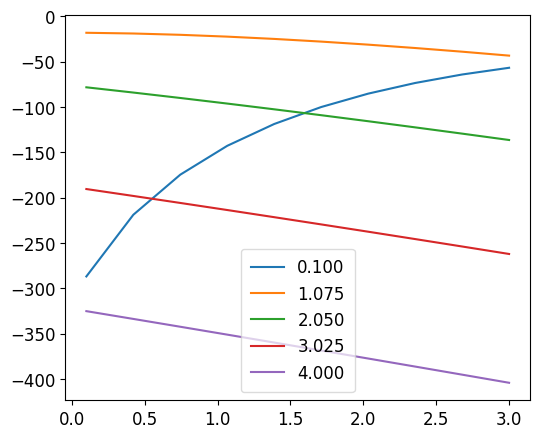

In [115]:
mu = np.linspace(0.1,3.,10)
epsilon = np.linspace(0.1,4,5)

for e in range(len(epsilon)):

    Posterior = np.zeros_like(mu)
    
    for j in range(len(mu)):
        Posterior[j] = LogPosterior(np.array([mu[j],epsilon[e]]),n,b,s)
    
    plt.plot(mu,Posterior,label='%.3f'%(epsilon[e]))
    
plt.legend()

# Algoritmo de metropolis

In [149]:
nll = lambda *p: LogPosterior(*p)
# Testing the posterior
pt = np.array([0.4,1.])
nll(pt,n,b,s)

-17.977999073694395

In [150]:
# Algoritmo de metropolis
n_walkers, n_params = 5,2
p0 = np.zeros((n_walkers,n_params))
p0[:,0] = 3.0
p0 += np.random.rand(n_walkers,n_params)


In [151]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, nll, args=(n,b,s))
pos,prob,state = sampler.run_mcmc(p0, 2000, progress = True)

100%|████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 227.91it/s]


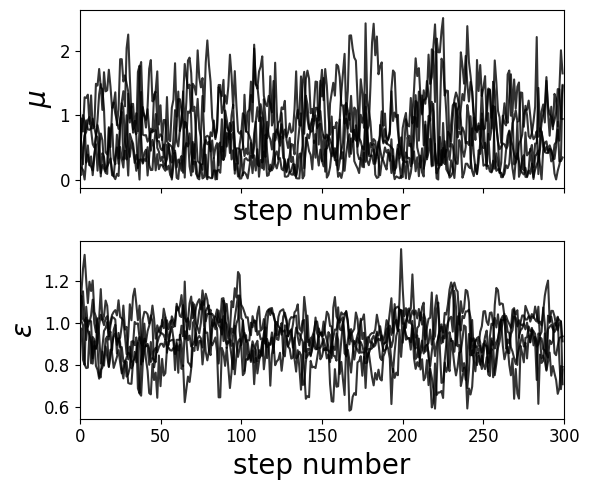

In [152]:
fig, axes = plt.subplots(n_params, sharex=True)

samples = sampler.get_chain(discard=500, thin=5)
labels = [r"$\mu$",r"$\epsilon$"]

for i in range(n_params):

    ax = axes[i]
    ax.plot(samples[:,:,i],"k", alpha=0.8)
    ax.set_xlim(0, len(samples))
    ax.set_xlabel('step number')
    ax.set_ylabel(labels[i])

    
axes[-1].set_xlabel("step number")

# Ajustar los márgenes automáticamente
plt.tight_layout()
plt.savefig('MCMC_1Channel.pdf')

In [154]:
flat_samples = sampler.get_chain(discard=500, thin=5, flat=True)
truths = np.percentile(flat_samples, 50, axis=0)
truths

array([0.62534691, 0.92708238])

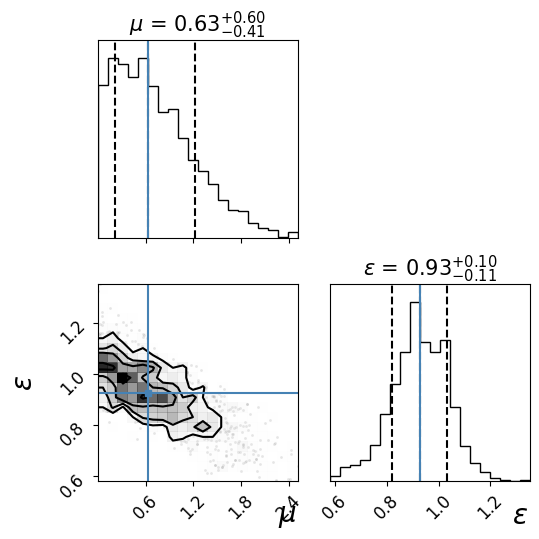

In [155]:
figure = corner.corner(flat_samples, 
                       truths=truths, 
                       labels=labels, 
                       quantiles=[0.16,0.5,0.84], 
                       show_titles=True,
                       title_kwargs={"fontsize":15})

axes = figure.axes

for ax in axes:
    ax.xaxis.set_label_coords(0.95,-0.1)

# Ajustar los márgenes automáticamente
plt.tight_layout()
plt.savefig('SamplingPosterior1Channel.pdf')

In [156]:
truths = np.percentile(flat_samples, 95, axis=0)
truths

array([1.67613176, 1.0903338 ])

In [157]:
flat_samples

array([[0.18294298, 1.07050914],
       [1.17773512, 0.96554171],
       [0.16662349, 1.09257668],
       ...,
       [0.34418849, 0.93578784],
       [0.94407939, 0.78961793],
       [1.47388311, 0.70719012]])